In [1]:
from PIL import Image
import torch
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-base",
    ffn=True,
    transformer_d_model=512,
    transformer_d_ff=2048,
    transformer_d_kv=64,
    transformer_num_heads=8,
    transformer_num_layers=4,
    transformer_num_decoder_layers=4,
    image_vocab_size=16384,
    loc_vocab_size=1000,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=256,
    max_target_length=256,
    # Train setting
    pretrain=True, 
    # Dir setting
    root_dir="/data01/",
    result_dir="results/pretrain/imagenet/enc4_dec4",
)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = MyModel(args).to(device)
model.load(result_name='best.pth')

In [4]:
from transformers import AutoTokenizer
from torchvision import transforms
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(1000)] + [f"<img_{i}>" for i in range(args.image_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [5]:
pattern = r"<img_(\d+)>"

import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

# ImageNet

In [157]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='imagenet', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='imagenet', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

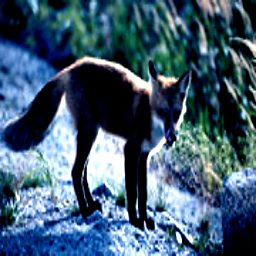

src_text ['a<extra_id_0> of kit fox</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [188]:
src_image, tgt_image, src_text, tgt_text = train_dataset[10]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    src_text = src_text.unsqueeze(0).to(device)
    print('src_text',  tgt_tokenizer.batch_decode(src_text))
    tgt_text = tgt_text.unsqueeze(0).to(device)
    print('tgt_text',  tgt_tokenizer.batch_decode(tgt_text))

    output = model(src_image, src_text, tgt_text, return_loss=False, num_beams=4)
    preds = tgt_tokenizer.batch_decode(output)
    print('pred', preds)

# SUN397

In [145]:
from data import get_dataset

dataset = get_dataset(args, dataset_name='sun397', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))

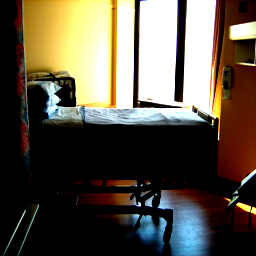

src_text ['<extra_id_0> photo of hospital room.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [153]:
src_image, tgt_image, src_text, tgt_text = train_dataset[0]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    src_text = src_text.unsqueeze(0).to(device)
    print('src_text', src_tokenizer.batch_decode(src_text))
    tgt_text = tgt_text.unsqueeze(0).to(device)
    print('tgt_text', tgt_tokenizer.batch_decode(tgt_text))

    output = model(src_image, src_text, tgt_text, return_loss=False)
    preds = tgt_tokenizer.batch_decode(output)
    print('pred', preds)

# Places365

In [ ]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='places365', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='places365', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

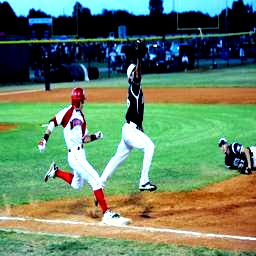

src_text ['a photo of baseball field.<extra_id_0><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

NameError: name 'model' is not defined

In [17]:
src_image, tgt_image, src_text, tgt_text = val_dataset[10]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    src_text = src_text.unsqueeze(0).to(device)
    print('src_text', src_tokenizer.batch_decode(src_text))
    tgt_text = tgt_text.unsqueeze(0).to(device)
    print('tgt_text', tgt_tokenizer.batch_decode(tgt_text))

    output = model(src_image, src_text, tgt_text, return_loss=False)
    preds = tgt_tokenizer.batch_decode(output)
    print('pred', preds)

# iNaturalist

In [6]:
from data import get_dataset
# train_dataset = get_dataset(args, dataset_name='inaturalist', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='inaturalist', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

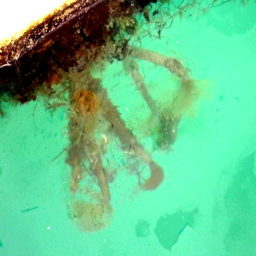

src_text ['a photo of Animalia Anne<extra_id_0>a Polychae<extra_id_1>a Sabelli<extra_id_2>a Sabellida<extra_id_3> Sabella spallanzanii.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

NameError: name 'model' is not defined

In [8]:
src_image, tgt_image, src_text, tgt_text = val_dataset[12]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    src_text = src_text.unsqueeze(0).to(device)
    print('src_text', src_tokenizer.batch_decode(src_text))
    tgt_text = tgt_text.unsqueeze(0).to(device)
    print('tgt_text', tgt_tokenizer.batch_decode(tgt_text))

    output = model(src_image, src_text, tgt_text, return_loss=False)
    preds = tgt_tokenizer.batch_decode(output)
    print('pred', preds)

# RedCaps

In [13]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="redcaps", src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))

In [ ]:
src_image, tgt_image, src_text, tgt_text = train_dataset[4]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    src_text = src_text.unsqueeze(0).to(device)
    print('src_text', src_tokenizer.batch_decode(src_text))
    tgt_text = tgt_text.unsqueeze(0).to(device)
    print('tgt_text', tgt_tokenizer.batch_decode(tgt_text))

    output = model(src_image, src_text, tgt_text, return_loss=False, num_beams=4)
    preds = tgt_tokenizer.batch_decode(output)
    print('preds', preds)

# 分割テスト

In [129]:
import random

mask_tokens: list

def generate_target_ids(input_id, mask_prob):
    """This function takes a list of sentences and generates the pair (input_ids, target_ids) for pretraining the
    model. It implements in a simple way the final T5 denoising objective, as per HuggingFace documentation.

    :param mask_prob: Probability of masking a token.
    :param input_ids: A list of sublists, where the sublists are sequences of input ids (tokenized sentences). This
        mutable sublists are modified within this function, masking the tokens that the model has to denoise for
        pretraining.
    :return: The correspondent target sequences of ids for each input sentence, with the unmasked tokens.
    """
    target_id = []
    masked_indexes = sorted(random.sample(range(0, len(input_id)),  # sample a word index in sentence
                                            min(int(mask_prob * len(input_id)),  # number of tokens masked
                                                len(mask_tokens) - 1)))  # but never more than special tokens available
    mask = [(i in masked_indexes)  # this is True or False
            for i in range(len(input_id))]
    i = 0
    end = len(input_id)
    masked_spans_counter = 0
    while i < end:
        if mask[i]:
            current_words_masked = [input_id[i]]
            input_id[i] = mask_tokens[masked_spans_counter]
            masked_spans_counter += 1
            while i + 1 < end and mask[i + 1]:
                current_words_masked.append(input_id[i + 1])
                del input_id[i + 1]
                del mask[i + 1]
                end -= 1
            target_id.extend(current_words_masked)
        else:
            if len(target_id) == 0 or target_id[-1] != mask_tokens[masked_spans_counter]:
                target_id.append(mask_tokens[masked_spans_counter])
        i += 1
    return target_id

In [130]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-base")
mask_tokens = tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'Thank you for inviting me to your party last week. I had a wonderful time.'
sequence = tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)[
    "input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
sequence = torch.tensor(sequence)
sequence = torch.nn.functional.pad(sequence, (0, 512 - len(sequence)), 'constant', 0)
print(sequence.shape)
target_id = torch.tensor(target_id)
target_id = torch.nn.functional.pad(target_id, (0, 512 - len(target_id)), 'constant', 0)
print(target_id.shape)
print(tokenizer.decode(sequence))
print(tokenizer.decode(target_id))

torch.Size([512])
torch.Size([512])
Thank you<extra_id_0> inviting me to your party last week.<extra_id_1> had a wonderful time.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

/opt/conda/envs/mmm/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [138]:
mask_tokens = src_tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'a photo of dog.'
sequence = tgt_tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)["input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
print(sequence)
print(tgt_tokenizer.decode(sequence))
print(target_id)
print(tgt_tokenizer.decode(target_id))

[32099, 9, 1202, 13, 1782, 5, 1]
<extra_id_0>a photo of dog.</s>
[3, 32098]
<extra_id_1>


In [11]:
src_tokenizer.pad_token_id

0